<a href="https://colab.research.google.com/github/smpark0520/ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD_%EA%B0%80%EC%9D%B4%EB%93%9C_%EA%B0%9C%EC%A0%952%ED%8C%90_ch8_10_11_p_566_583.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 10 텍스트 분석 실습 — 캐글 Mercari Price Suggestion Challenge

- 개요:  
  일본의 온라인 쇼핑몰 Mercari에서 제품 가격을 예측하는 머신러닝 과제

  판매자가 입력한 제품명, 브랜드명, 카테고리, 제품 설명 등의 정보를 바탕으로 예상 판매 가격을 예측하는 모델을 개발



- 주요 컬럼 설명

| 컬럼명              | 설명                                  |
|---------------------|---------------------------------------|
| train_id            | 데이터 ID                             |
| name                | 제품명                                |
| item_condition_id   | 판매자가 제공하는 제품 상태 (1~5)     |
| category_name       | 제품 카테고리                         |
| brand_name          | 브랜드 이름                           |
| price               | 예측 대상. 제품 가격                  |
| shipping            | 배송비 부담 (1: 판매자, 0: 구매자)    |
| item_description    | 제품 설명 (텍스트 형태)               |




- 타깃 변수:  
  - `price` (제품 가격)

- 특징:  
  - 정형 데이터(카테고리, 브랜드 등)와  
    비정형 데이터(제품 설명 텍스트)를 함께 활용하는 회귀 문제


### 데이터 전처리

In [15]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('/content/drive/MyDrive/25-1 ESAA OB/mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [17]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


- brand_name
  - 전체 1,482,535건 중 849,853건만 값이 존재
  - 약 43%만 Not null, 나머지는 Null  
  - 가격에 영향을 줄 수 있는 중요한 변수지만 결측치가 많음

- category_name
  - 약6,300건의 Null 값 존재  
  - 비교적 적은 수준

- item_description  
  - 6건의 Null 값만 존재  
  - 영향이 미미함

> 👉 위 Null 값들은 모델 학습을 위해 적절한 문자열(예: `"missing"` 또는 `"No description"`)로 치환하여 처리할 예정


- `price`는 제품의 실제 판매 가격으로, 양수이며 분포가 한쪽으로 치우쳐 있을 가능성이 높음
- 왜곡된 분포는 모델의 성능에 영향을 줄 수 있으므로, 보통 로그 변환을 통해 정규 분포에 가깝게 조정


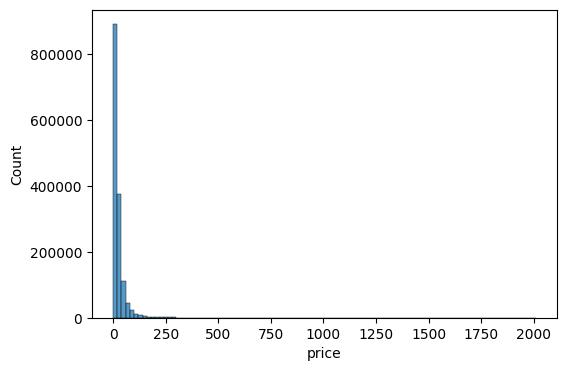

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df=mercari_df['price']
plt.figure(figsize=(6,4))
sns.histplot(y_train_df, bins=100)
plt.show()

- price 값이 비교적 적은 가격을 가진 데이터 값에 왜곡돼 분포돼 있음
- Price 칼럼을 로그 값으로
변환한 뒤 분포도를 다시 살펴보기

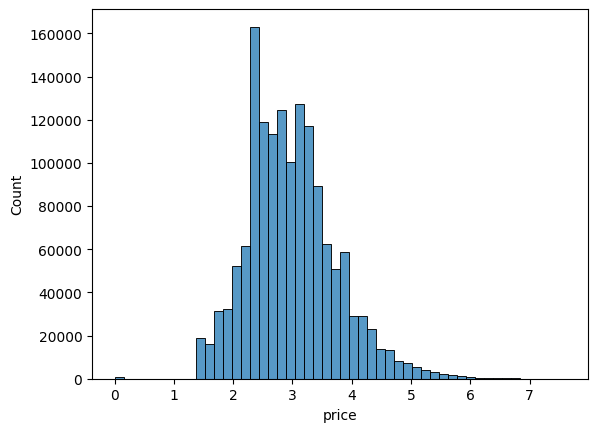

In [5]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins=50)
plt.show()

- 로그 값으로 변환하면 price 값이 비교적 정규 분포에 가까운 데이터 분포
- 데이터 세트의 price 칼럼을 원래 값에서 로그로 변환된 값으로 변경

In [6]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

,price
0,2.397895
1,3.970292
2,2.397895


- shipping과 item_condition_id 값의 유형

In [19]:
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 shipping
0    819435
1    663100
Name: count, dtype: int64
item_condition_id 값 유형:
 item_condition_id
1    640549
3    432161
2    375479
4     31962
5      2384
Name: count, dtype: int64


- shipping 칼럼은 배송비 부담 여부를 나타내며, 값이 비교적 균일하게 분포

- item_condition_id는 제품 상태를 나타내며, 1, 2, 3 값이 대부분

- item_description은 결측치는 거의 없으나, 'No description yet'으로 표시된 값이 다수 존재하므로 해당 개수 파악 필요

In [20]:
boolean_cond=mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

np.int64(82489)

- item_description이 'No description yet'으로 되어 있는 행은 총 82,489건

- 해당 값은 실질적인 설명이 없어 Null과 동일하게 간주되며, 적절한 문자열로 대체할 예정

- category_name은 '/'로 구분된 대, 중, 소분류 문자열로 구성되어 있음 (예: Men/Tops/T-shirts)

- 이를 기반으로 split_cat() 함수를 만들어 대분류(cat_dae), 중분류(cat_jung), 소분류(cat_so)로 나눔

- category_name이 Null인 경우 오류 방지를 위해 세 분류 모두 'Other Null'로 처리

- apply(lambda x: ...) + zip(*)을 활용해 리스트 반환값을 각 컬럼에 쉽게 분리하여 저장

- 약 6,300건의 Null값이 존재하므로 해당 값 처리에 주의 필요

In [22]:
# apply lambda에서 호출되는 대, 증, 소 분할 함수 생성, 대, 중, 소 값을 리스트로 반환
def split_cat(category_name):
  try:
    return category_name.split('/')
  except:
      return ['Other_Null', 'Other_Null', 'Other_Null']
# 위의 split_cat()을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에 생성
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류의 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형:\n', mercari_df['cat_dae'].value_counts())
print('중분류 개수:\n', mercari_df['cat_jung'].nunique())
print('소분류 개수:\n', mercari_df['cat_so'].nunique())

대분류 유형:
 cat_dae
Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: count, dtype: int64
중분류 개수:
 114
소분류 개수:
 871


- 대분류의 경우 Women, Beauty, Kids 등의 분류가 매우 많음
- 중분류 유형은 114개, 소분류는 817개로 구성

- brand_name, category_name, item_description의 Null 값은 모두 'Other_Null'로 일괄 대체

- 특히 brand_name은 결측치가 많고 다른 값으로의 대체가 어렵기 때문에 동일한 문자열로 처리

- fillna()로 Null 값을 변경한 후, mercari_df.isnull().sum()을 통해 모든 컬럼의 Null 값이 제거되었는지 확인

In [23]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 칼럼별로 Null 값 건수 확인. 모두 0이 나와야함
mercari_df.isnull().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,0
brand_name,0
price,0
shipping,0
item_description,0
cat_dae,0
cat_jung,0


### 피처 인코딩과 피처 벡터화

- Mercari 데이터는 문자열 칼럼이 많아 모델 입력을 위해 적절한 인코딩 또는 벡터화가 필요함

- 예측 대상은 price이며, 회귀 모델(선형 회귀, 회귀 트리 등)을 사용할 예정

- 선형 회귀 모델 특성상 원-핫 인코딩이 선호되므로, 인코딩 대상 피처는 원-핫 방식으로 처리

- 텍스트 피처는 길이에 따라 변환 방식 선택

 - 짧은 텍스트: CountVectorizer 사용

 - 긴 텍스트: TF-IDF 벡터화 적용 예정


- 첫 번째 인코딩 대상 칼럼: brand_name

- 상품 브랜드명 정보를 담고 있으며, 유형 수와 상위 5개 브랜드명을 확인하여 인코딩 방향을 설정할 예정

In [25]:
print('brand name 의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])

brand name 의 유형 건수 : 4810
brand name sample 5건 : 
 brand_name
Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: count, dtype: int64


- brand_name은 대부분 명확한 문자열 형태이므로 피처 벡터화 없이 인코딩만 적용

- 총 4,810개의 고유 브랜드가 존재하지만, ML 모델 학습에는 큰 문제 없으므로 원-핫 인코딩 적용 예정

-  name 속성이 어떤 유형으로 돼 있는지 유형 건수와 상품명을 7개만 출력

In [26]:
print('name의 종류 개수:', mercari_df['name'].nunique())
print('name sample 7건:\n'), mercari_df['name'][:7]

name의 종류 개수: 1225273
name sample 7건:



(None,
 0    MLB Cincinnati Reds T Shirt Size XL
 1       Razer BlackWidow Chroma Keyboard
 2                         AVA-VIV Blouse
 3                  Leather Horse Statues
 4                   24K GOLD plated rose
 5       Bundled items requested for Ruie
 6     Acacia pacific tides santorini top
 Name: name, dtype: object)

- `name` 속성은 1,225,273개의 고유 값으로 대부분 고유한 상품명  
  → 단어 수가 적고 텍스트 기반이므로 CountVectorizer로 피처 벡터화 적용  

- `category_name`은 전처리를 통해 `cat_dae`, `cat_jung`, `cat_so`로 분리됨  
  → 세 컬럼 모두 원-핫 인코딩 적용  

- `shipping`: 0 또는 1 값 → 원-핫 인코딩  
- `item_condition_id`: 1~5 범위의 값 → 원-핫 인코딩  

> 요약: 범주형 데이터는 모두 원-핫 인코딩, 텍스트는 형태에 따라 Count 또는 TF-IDF 벡터화 적용 예정

- item_description은 상품 설명을 담고 있으며, 전체 데이터에서 가장 긴 텍스트 길이를 가짐

- 사전 확인을 위해 평균 텍스트 길이와 예시 텍스트 2개를 추출하여 내용 및 형태를 파악할 계획

In [27]:
pd.set_option('max_colwidth', 200)

#item_description의 평균 문자열 크기
print('item_description의 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description의 평균 문자열 크기: 145.71139703278507


,item_description
0,No description yet
1,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.


- 평균 문자열이 145자로 비교적 크므로 해당 칼럼은 TF-IDF로 변환

name 컬럼은 CountVectorizer를 이용해 벡터화하고, item_description 컬럼은 TfidfVectorizer로 벡터화

- CountVectorizer: 기본 파라미터 사용

- TfidfVectorizer:

 - max_features=50000

 - ngram_range=(1, 3) (unigram ~ trigram)

 - stop_words='english' (불용어 제거)

In [30]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


- X_name, X_descp는 희소 행렬

- 범주형 칼럼들도 LabelBinarizer(sparse_output=True)로 희소 행렬 변환

- 모든 희소 행렬은 scipy.sparse.hstack()으로 열 방향 결합

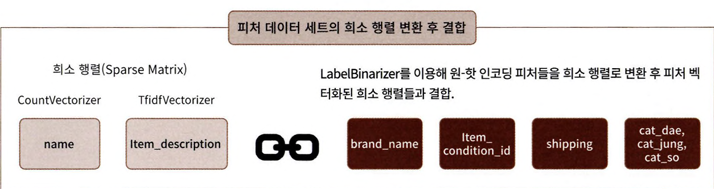

- 인코딩 대상 칼럼을 모두 LabelBinarizer로 원-핫 인코딩 변환

In [32]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [34]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


- 인코딩 결과는 csr_matrix 타입의 희소 행렬 형태

- brand_name → 4810개, cat_so → 871개 인코딩 칼럼 생성됨

- 벡터화된 텍스트 칼럼과 함께 결합 예정이므로, 칼럼 수 많아도 문제 없음

- hstack()으로 피처 벡터화된 데이터와 희소 인코딩 데이터를 모두 수평 결합함

- 결합된 데이터는 최종 ML 모델의 입력 데이터로 사용됨

- 현재는 타입과 shape만 확인 후, del과 gc.collect()로 메모리 절약을 위해 삭제

- 추후 모델링 시 다시 결합하여 사용 예정

In [42]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합.
X_features_sparse=hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제,
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 161569)


2919

### 릿지 회귀 모델 구축 및 평가

- 여러 알고리즘과 희소 행렬로 테스트할 예정이므로 코드 함수화

- 평가 지표로 RMSLE(Root Mean Squared Log Error) 사용

- RMSLE는 RMSE에 로그를 취한 방식

- 낮은 가격보다 높은 가격에서 발생하는 오류 과대평가 방지 목적

$RMSLE = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} \left( \log(p_i + 1) - \log(a_i + 1) \right)^2 }$

- 예측값은 $p_i$, 실제값은 $a_i$로 표현

- 로그 변환된 price 사용

- 예측 결과도 로그 스케일

- RMSLE 계산 전 지수 변환 필요 (np.expm1)

- 복원된 값으로 RMSLE 계산 (evaluate_org_price() 함수에서 처리)

In [46]:
def rmsle(y, y_pred):
  # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
  return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):

  # 원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요.
  preds_exmpm = np.expm1(preds)
  y_test_exmpm = np.expm1(y_test)

  # rmsle로 RMSLE 값 추출
  rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
  return rmsle_result

- model_train_predict() 함수 생성

- 인자: model (회귀 모델), matrix_list (결합할 희소 행렬 리스트)

- hstack(matrix_list)로 희소 행렬 결합

- train_test_split()로 학습/평가용 데이터 분리 (test size = 20%)

- 학습: model.fit()

- 예측: model.predict()

- 평가: evaluate_org_price()로 RMSLE 출력

In [47]:
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
  # scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
  X= hstack(matrix_list).tocsr()

  X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'], test_size=0.2, random_state=156)

  # 모델 학습 및 예측
  model.fit(X_train, y_train)
  preds = model.predict(X_test)

  del X, X_train, X_test, y_train
  gc.collect()

  return preds, y_test

- item_description 피처 제외한 희소 행렬 리스트 → X_name, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so

- item_description 피처 포함한 희소 행렬 리스트 → 위 + X_descp

- 두 리스트 각각 model_train_predict() 함수에 입력

- 모델: Ridge(alpha=1.0)

- 두 경우의 RMSLE 비교해 item_description 피처의 영향 확인

In [48]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, \
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:', evaluate_org_price(y_test, linear_preds))

<ipython-input-46-712e9a5af9c0>:11: RuntimeWarning: overflow encountered in expm1
  preds_exmpm = np.expm1(preds)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)


Item Description을 제외했을 때 rmsle 값: inf
Item Description을 포함한 rmsle 값: inf


<ipython-input-46-712e9a5af9c0>:11: RuntimeWarning: overflow encountered in expm1
  preds_exmpm = np.expm1(preds)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)


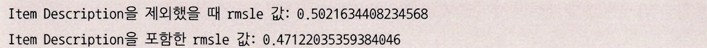

- Item Description을 포함했을 때 rmsle 값이 많이 감소

### LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

- LightGBM 회귀 모델 사용

- n_estimators=200으로 설정해 예측 성능 측정

- 병렬 환경이라면 더 크게(n_estimators > 1000) 설정 가능

- 이후 Ridge + LightGBM 예측값 간단 앙상블 예정

In [ ]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model = lgbm_model, matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:', evaluate_org_price(y_test, lgbm_preds))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM rmsle 값: 0.4563962127849484

In [ ]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:', evaluate_org_price(y_test, preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.4467272727321774